$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Machine \space Learning \space 2 $$
$$ KMeans \space and \space GMM $$

# `00` BMI Clustering Analysis 🏋️‍♂️📊



- `Body Mass Index (BMI)` is a measure of body fat based on weight and height.  
- This is using `K-Means` and `GMM` to cluster individuals into different BMI categories.  
- This can help businesses tailor fitness programs, dietary plans, and personalized health recommendations.
---

# `01` Import Necessary Libraries

In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.stats import multivariate_normal
from ipywidgets import interact
from IPython.display import display

# `02` Load Data

In [91]:
BMI = pd.read_csv("/content/Clustering_gmm.csv")
BMI.head().style.background_gradient(cmap='Blues')

,Weight,Height
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679


# `03` EDA

In [92]:
BMI.shape

(500, 2)

In [93]:
BMI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  500 non-null    float64
 1   Height  500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [94]:
#Check duplicates
BMI.duplicated().sum()

0

In [95]:
BMI.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Weight,500.000000,61.270240,5.196976,50.433644,57.772791,61.961518,65.439332,70.700456
Height,500.000000,169.515781,4.805095,160.182164,166.607599,169.726252,172.837284,178.894770


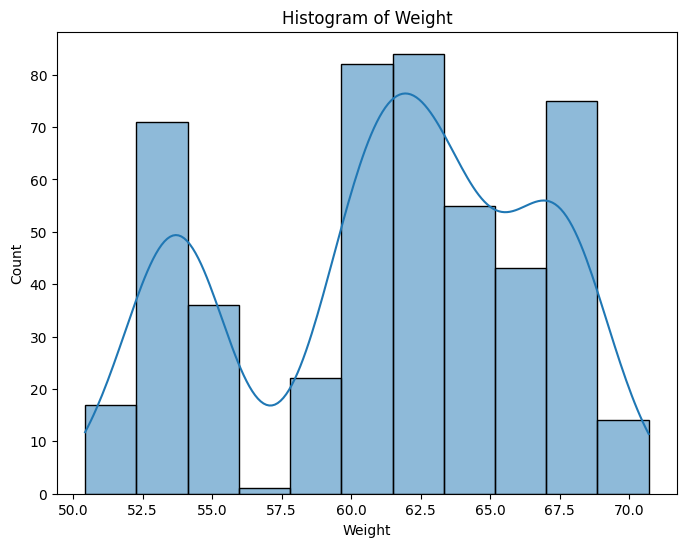

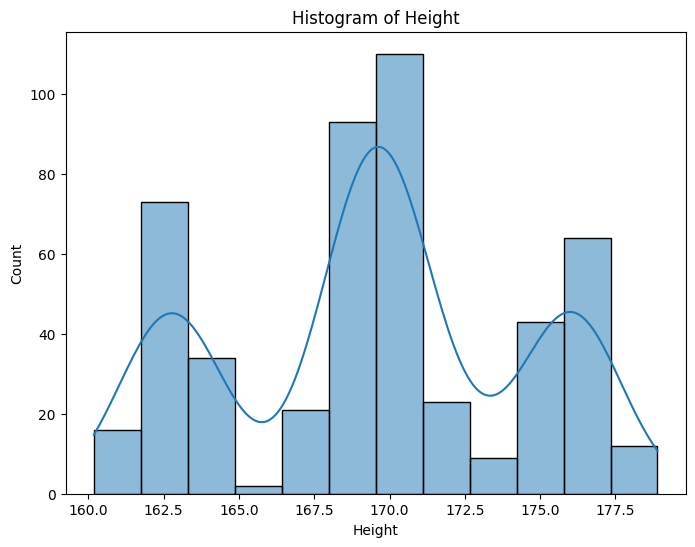

In [96]:
for col in BMI.columns :
    plt.figure(figsize=(8,6))
    sns.histplot(data = BMI , x= col , kde=True )
    plt.title(f"Histogram of {col}")
    plt.show()

In [97]:
Q1 = BMI.quantile(0.25)
Q3 = BMI.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (BMI < lower_bound) | (BMI > upper_bound)

outlier_counts = outliers_mask.sum(axis=0)

total_rows = BMI.shape[0]
outlier_percentage = (outlier_counts / total_rows) * 100

outliers_summary = pd.DataFrame({
    "Number of Outliers": outlier_counts,
    "Outlier Percentage": outlier_percentage
})

outliers_summary.style.background_gradient(cmap='Blues')

,Number of Outliers,Outlier Percentage
Weight,0,0.000000
Height,0,0.000000


In [98]:
BMI['BMI'] = BMI['Weight'] / ((BMI['Height'] / 100) ** 2)

In [99]:
BMI.head().style.background_gradient(cmap='Blues')

,Weight,Height,BMI
0,67.062924,176.086355,21.628733
1,68.804094,178.388669,21.621198
2,60.930863,170.284496,21.012954
3,59.733843,168.691992,20.990922
4,65.431230,173.763679,21.670408


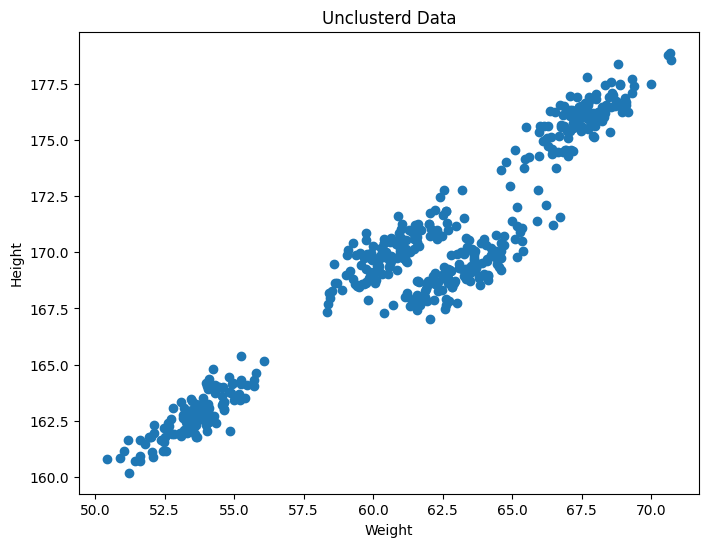

In [100]:
plt.figure(figsize=(8, 6))
plt.scatter(BMI['Weight'], BMI['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Unclusterd Data')
plt.show()

<Axes: >

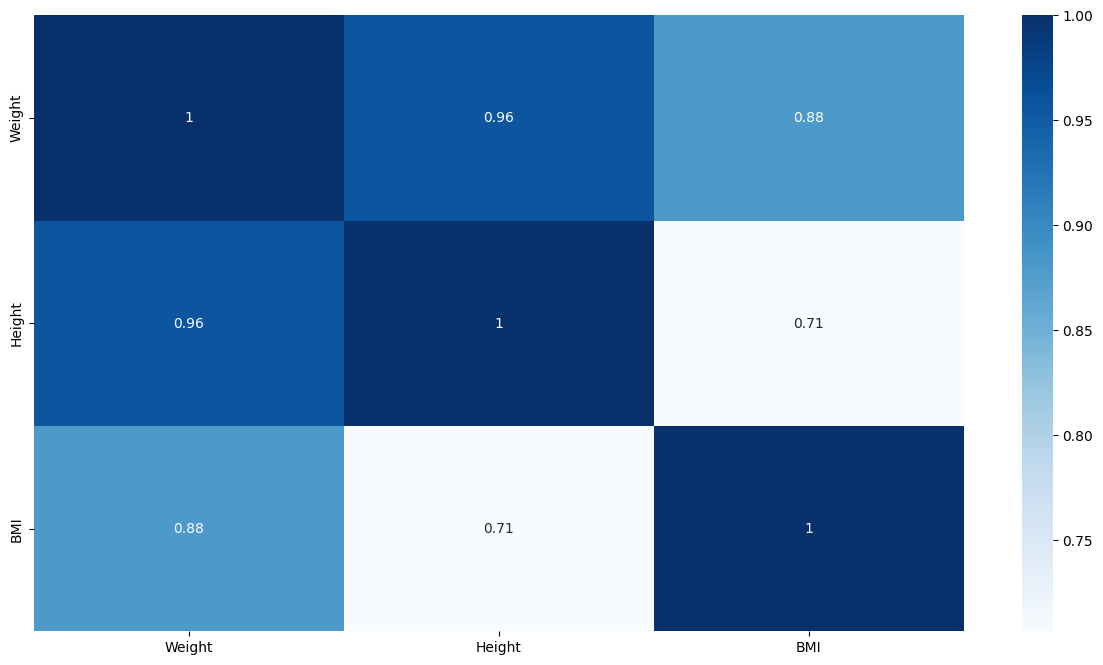

In [101]:
plt.figure(figsize=(15, 8))
sns.heatmap(BMI.corr(), cmap = 'Blues' ,annot=True)

# `04` Preprocessing

In [102]:
BMI = BMI.drop(['Weight',	'Height'], axis=1)

<Axes: xlabel='BMI', ylabel='Count'>

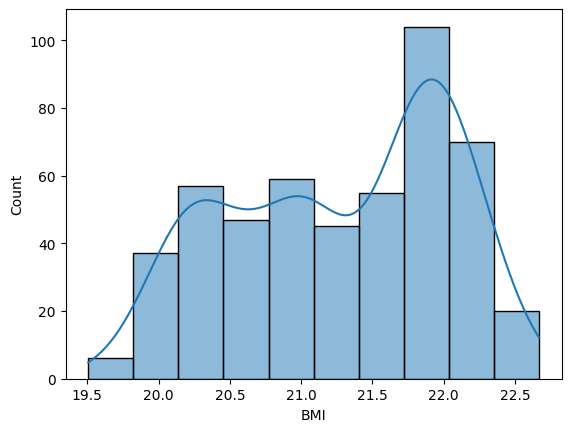

In [103]:
sns.histplot(data = BMI , x= 'BMI' , kde=True )

In [104]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(BMI)

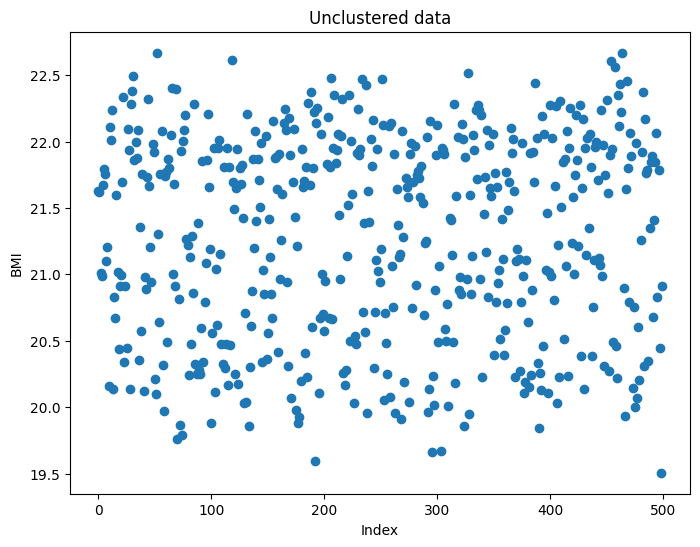

In [105]:
plt.figure(figsize=(8, 6))
plt.scatter(BMI.index, BMI['BMI'])
plt.xlabel('Index')
plt.ylabel('BMI')
plt.title('Unclustered data')
plt.show()

---
# `05` K-Means

##`i` From Scratch

In [106]:
def kmeans(X, n_clusters, n_iterations=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, n_clusters, replace=False)]
    clusters = np.zeros(n_samples)

    for i in range(n_iterations):
        # Assign clusters
        distances = np.array([[np.linalg.norm(x - c) for c in centroids] for x in X])
        clusters = np.argmin(distances, axis=1)

        # Compute new centroids
        new_centroids = np.array([X[clusters == k].mean(axis=0) for k in range(n_clusters)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, clusters


In [107]:
# Fit KMeans from scratch
centroids, clusters = kmeans(data_scaled, n_clusters=3, n_iterations=30)

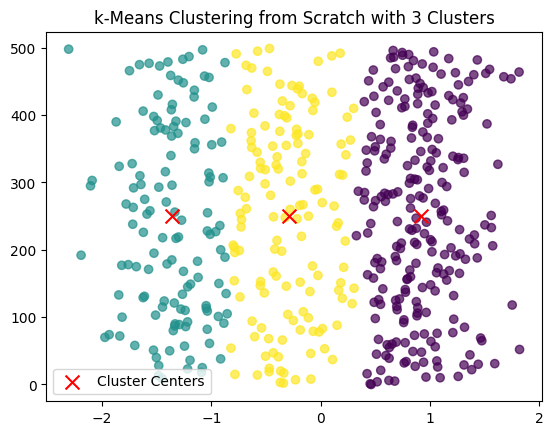

In [108]:
# Visualize the results
y_values = np.arange(data_scaled.shape[0])
plt.scatter(data_scaled[:, 0], y_values, c=clusters, cmap='viridis', alpha=0.7)

plt.scatter(centroids[:, 0], [y_values.mean()] * len(centroids), marker='x', s=100, color='red', label='Cluster Centers')
plt.legend()
plt.title(f'k-Means Clustering from Scratch with 3 Clusters')
plt.show()

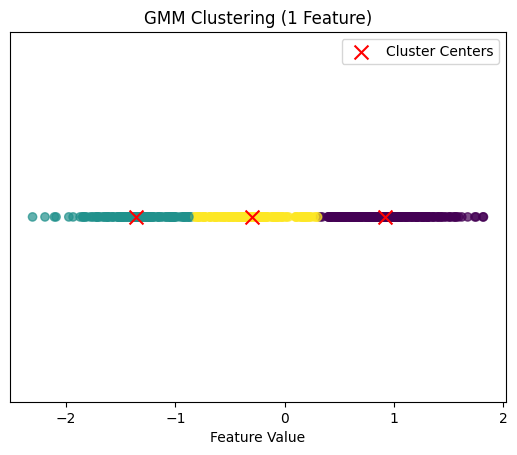

In [109]:
plt.scatter(data_scaled[:, 0], np.zeros_like(data_scaled[:, 0]), c=clusters, cmap='viridis', alpha=0.7)

# Plot cluster centers along the x-axis
plt.scatter(centroids[:, 0], np.zeros_like(centroids[:, 0]), marker='x', s=100, color='red', label='Cluster Centers')

plt.legend()
plt.title('GMM Clustering (1 Feature)')
plt.xlabel('Feature Value')
plt.yticks([])
plt.show()

## `ii` Using Sklearn

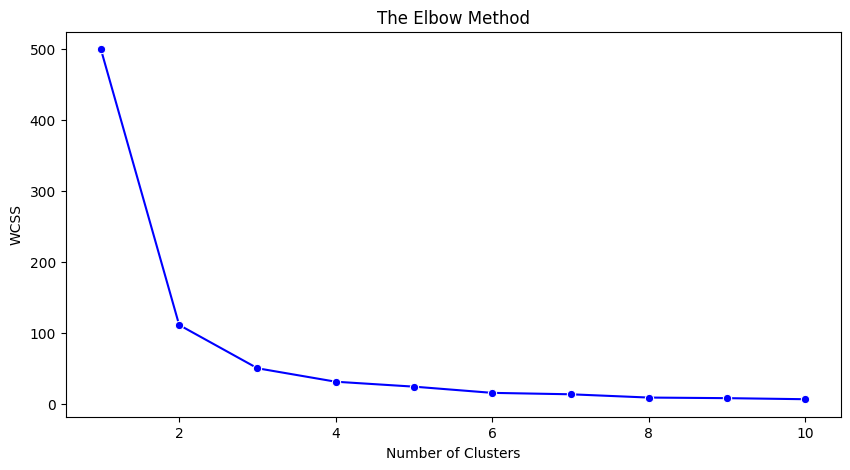

In [110]:
wcss = []
for i in range(1, 11):
    # Use a different variable name to avoid shadowing the class
    kmeans_model = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_model.fit(data_scaled)
    wcss.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 11), y=wcss, marker='o', color='blue')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [132]:
def show_clusters(n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = model.fit_predict(data_scaled)


    plot_data = pd.DataFrame(data_scaled, columns=["BMI"])
    plot_data["Cluster_KMeans"] = clusters


    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=np.arange(len(plot_data)), y=plot_data["BMI"], hue=plot_data["Cluster_KMeans"], palette="viridis", alpha=0.7)

    plt.xlabel("Individuals")
    plt.ylabel("BMI")
    plt.title(f"BMI Clusters (K={n_clusters})")
    plt.legend(title="Cluster")
    plt.show()

interact(show_clusters, n_clusters=(2, 6, 1))
display()


interactive(children=(IntSlider(value=4, description='n_clusters', max=6, min=2), Output()), _dom_classes=('wi…

In [112]:
# Fit KMeans using sklearn
kmeans = KMeans(n_clusters=3 , random_state=42)
kmeans.fit(data_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

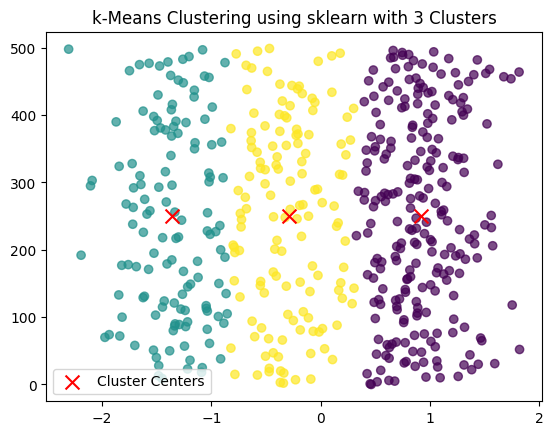

In [113]:
# Visualize the results
y_values = np.arange(data_scaled.shape[0])
plt.scatter(data_scaled[:, 0], y_values, c=labels, cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], [y_values.mean()] * len(centroids), marker='x', s=100, color='red', label='Cluster Centers')
plt.legend()
plt.title(f'k-Means Clustering using sklearn with 3 Clusters')
plt.show()

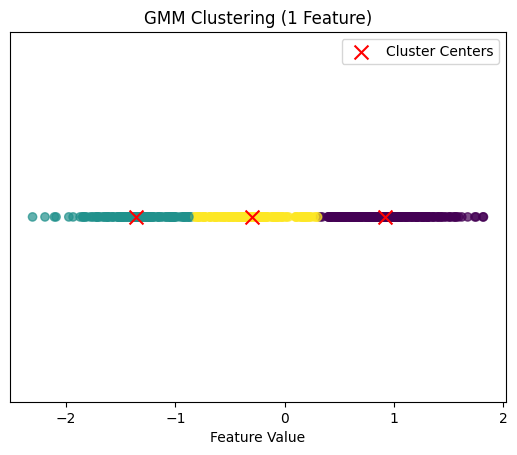

In [114]:
plt.scatter(data_scaled[:, 0], np.zeros_like(data_scaled[:, 0]), c=labels, cmap='viridis', alpha=0.7)

# Plot cluster centers along the x-axis
plt.scatter(centroids[:, 0], np.zeros_like(centroids[:, 0]), marker='x', s=100, color='red', label='Cluster Centers')

plt.legend()
plt.title('GMM Clustering (1 Feature)')
plt.xlabel('Feature Value')
plt.yticks([])
plt.show()

In [115]:
# Calculate Silhouette Score for KMeans
silhouette_avg_kmeans = silhouette_score(data_scaled, labels)
print(f"Silhouette Score for KMeans: {silhouette_avg_kmeans}")

Silhouette Score for KMeans: 0.6348254717698485


---
# `06` GMM

##`i` From Scratch

In [116]:
# Implement GMM from scratch
def gmm(X, n_clusters, n_iterations=100):
    n_samples, n_features = X.shape
    means = X[np.random.choice(n_samples, n_clusters, replace=False)]
    covariances = [np.eye(n_features)] * n_clusters
    weights = np.ones(n_clusters) / n_clusters

    for i in range(n_iterations):
        # E-step
        responsibilities = []
        for k in range(n_clusters):
            numerator = multivariate_normal.pdf(X, mean=means[k], cov=covariances[k]) * weights[k]
            responsibilities.append(numerator)
        responsibilities = np.array(responsibilities).T
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        total_resp = np.sum(responsibilities, axis=0)
        weights = total_resp / n_samples
        means = (responsibilities.T @ X) / total_resp[:, np.newaxis]
        for k in range(n_clusters):
            diff = X - means[k]
            covariances[k] = ((responsibilities[:, k] * diff.T) @ diff) / total_resp[k]

    return means, covariances, weights

In [117]:
# Fit GMM from scratch
estimated_means, estimated_covariances, estimated_weights = gmm(data_scaled, 3)

In [118]:
# Assign samples to clusters
def assign_clusters(X, means, covariances, weights):
    n_samples = X.shape[0]
    n_clusters = len(means)
    responsibilities = np.zeros((n_samples, n_clusters))
    for k in range(n_clusters):
        responsibilities[:, k] = multivariate_normal.pdf(X, mean=means[k], cov=covariances[k]) * weights[k]
    cluster_assignments = np.argmax(responsibilities, axis=1)
    return cluster_assignments

predicted_assignments = assign_clusters(data_scaled, estimated_means, estimated_covariances, estimated_weights)

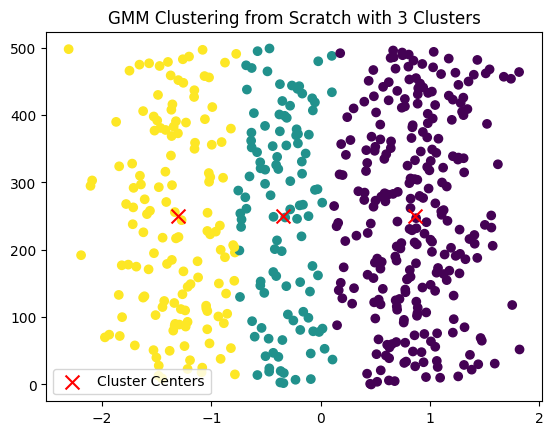

In [119]:
# Visualize the results
y_values = np.arange(data_scaled.shape[0])
plt.scatter(data_scaled[:, 0], y_values, c=predicted_assignments, cmap='viridis')

plt.scatter(estimated_means[:, 0], [y_values.mean()] * len(estimated_means), marker='x', s=100, color='red', label='Cluster Centers')
plt.legend()
plt.title(f'GMM Clustering from Scratch with 3 Clusters')
plt.show()

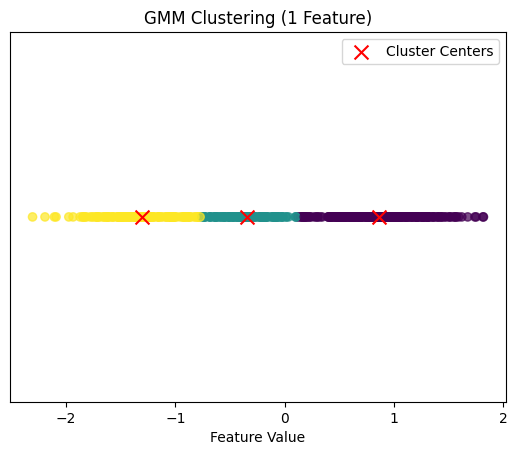

In [120]:
plt.scatter(data_scaled[:, 0], np.zeros_like(data_scaled[:, 0]), c=predicted_assignments, cmap='viridis', alpha=0.7)

# Plot cluster centers along the x-axis
plt.scatter(estimated_means[:, 0], np.zeros_like(estimated_means[:, 0]), marker='x', s=100, color='red', label='Cluster Centers')

plt.legend()
plt.title('GMM Clustering (1 Feature)')
plt.xlabel('Feature Value')
plt.yticks([])
plt.show()

In [121]:
# Calculate Silhouette Score for GMM
silhouette_avg_gmm = silhouette_score(data_scaled, predicted_assignments)
print(f"Silhouette Score for GMM: {silhouette_avg_gmm}")

Silhouette Score for GMM: 0.6156922805574885


## `ii` Using Sklearn

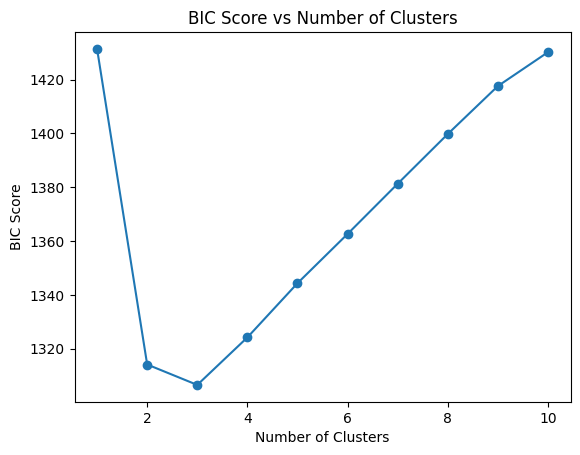

In [122]:
# Using Gaussian Mixture Model
n_clusters = range(1, 11)
bic_scores = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=0, max_iter= 1000000000)
    gmm.fit(data_scaled)
    bic_scores.append(gmm.bic(data_scaled))

# Plot BIC scores to find optimal number of clusters
plt.plot(n_clusters, bic_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('BIC Score vs Number of Clusters')
plt.show()



# Fit GMM with the optimal number of clusters
optimal_n_clusters = np.argmin(bic_scores) + 1
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=0)
gmm.fit(data_scaled)

# Predict clusters
predicted_clusters = gmm.predict(data_scaled)

In [123]:
gmm = GaussianMixture(n_components= 3 , random_state=0, max_iter = 100000)
gmm.fit(data_scaled)
predicted_clusters = gmm.predict(data_scaled)

In [124]:
gmm.means_

array([[ 0.88200348],
       [-0.34269984],
       [-1.33810438]])

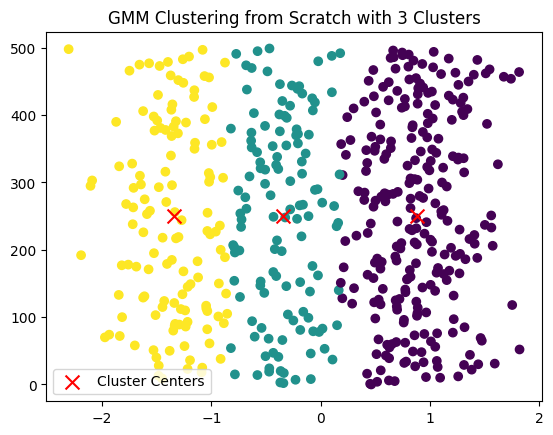

In [125]:
# Visualize the results
y_values = np.arange(data_scaled.shape[0])
plt.scatter(data_scaled[:, 0], y_values, c=predicted_clusters, cmap='viridis')

plt.scatter(gmm.means_, [y_values.mean()] * len(estimated_means), marker='x', s=100, color='red', label='Cluster Centers')
plt.legend()
plt.title(f'GMM Clustering from Scratch with 3 Clusters')
plt.show()

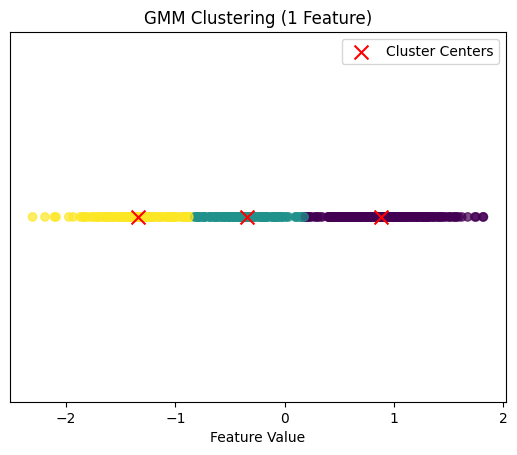

In [126]:
plt.scatter(data_scaled[:, 0], np.zeros_like(data_scaled[:, 0]), c=predicted_clusters, cmap='viridis', alpha=0.7)

# Plot cluster centers along the x-axis
plt.scatter(gmm.means_, np.zeros_like(gmm.means_), marker='x', s=100, color='red', label='Cluster Centers')

plt.legend()
plt.title('GMM Clustering (1 Feature)')
plt.xlabel('Feature Value')
plt.yticks([])
plt.show()

In [127]:
# Calculate Silhouette Score for GMM
silhouette_avg_gmm = silhouette_score(data_scaled, predicted_clusters)
print(f"Silhouette Score for GMM: {silhouette_avg_gmm}")

Silhouette Score for GMM: 0.6308868218113541


---
# `06` Business Insights & Recommendations

In [128]:
original_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Original BMI Cluster Centers:", original_centers.flatten())

Original BMI Cluster Centers: [21.97882014 20.22961694 21.04880874]


In [129]:
original_centers_gmm = scaler.inverse_transform(gmm.means_)
print("Original BMI Cluster Centers (GMM):", original_centers_gmm.flatten())

Original BMI Cluster Centers (GMM): [21.95067277 21.01186201 20.24882294]


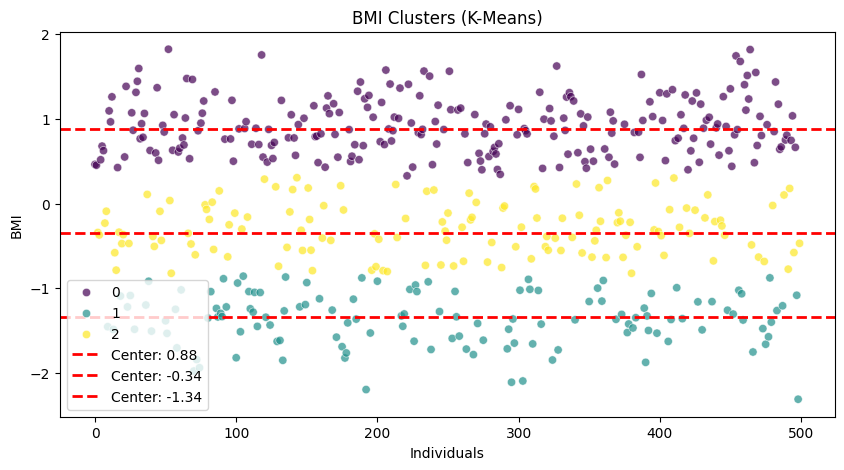

In [130]:
plt.figure(figsize=(10, 5))

data_scaled = pd.DataFrame(data_scaled, columns=['BMI'])
data_scaled['Cluster_KMeans'] = kmeans.labels_

sns.scatterplot(x=np.arange(len(data_scaled)), y=data_scaled["BMI"], hue=data_scaled["Cluster_KMeans"], palette="viridis", alpha=0.7)

for center in gmm.means_:
    plt.axhline(y=center, color="red", linestyle="dashed", linewidth=2, label=f"Center: {center[0]:.2f}")  # Format center value

plt.xlabel("Individuals")
plt.ylabel("BMI")
plt.title("BMI Clusters (K-Means)")
plt.legend()
plt.show()

---
## Business Insights 🏆
- **Cluster 0 (BMI ~22):** Healthy individuals – potential market for fitness memberships and diet tracking apps.  
- **Cluster 1 (BMI ~20):** Slightly underweight individuals – ideal for weight gain products or high-calorie meal plans.  
- **Cluster 2 (BMI ~21):** Close to average BMI – they might need general health and maintenance programs.  

### 📢 **Recommendation**
Companies can design **personalized health & fitness plans** based on these insights to attract the right customers.
